In [ ]:
'''
VERSION 2 OF A U-Net MODEL
'''

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!mkdir myData

!unzip -uq "/content/drive/MyDrive/Colab Notebooks/labels.zip" -d "/content/myData"
!unzip -uq "/content/drive/MyDrive/Colab Notebooks/og_imgs.zip" -d "/content/myData"

In [ ]:
import glob
from PIL import Image


import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
#from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


In [ ]:
IMG_WIDTH = 96
IMG_HEIGHT = 256
IMG_CHANNELS = 1

TRAIN_PATH = '/content/myData/og_imgs/'
TEST_PATH = '/content/myData/labels/'

train_image_files = glob.glob(os.path.join(TRAIN_PATH, '*.tif'))
just_name_train_image_files = [os.path.basename(file) for file in train_image_files]

test_image_subfolders = [subfolder for subfolder in os.listdir(TEST_PATH) if os.path.isdir(os.path.join(TEST_PATH, subfolder))]

In [ ]:
X = np.zeros((len(train_image_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
y = np.zeros((len(train_image_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
cnt = 0

for subfolder in test_image_subfolders:
    subfolder_path = os.path.join(TEST_PATH, subfolder)

    # Load masks
    im1_file = glob.glob(os.path.join(subfolder_path, 'label.png'))
    im1 = tf.keras.preprocessing.image.load_img(im1_file[0], grayscale=True)

    mask = tf.keras.preprocessing.image.img_to_array(im1)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode = 'constant', preserve_range = True)
    y[cnt] = mask/75.0

    # Load images
    im2_file = glob.glob(os.path.join(subfolder_path, 'img.png'))
    im2 = tf.keras.preprocessing.image.load_img(im2_file[0], grayscale=True)

    x_img = tf.keras.preprocessing.image.img_to_array(im2)
    x_img = resize(x_img, (IMG_HEIGHT, IMG_WIDTH, 1), mode = 'constant', preserve_range = True)
    X[cnt] = x_img/255.0

    cnt +=1

/usr/local/lib/python3.10/dist-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [ ]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(178, 128, 128, 1)
(178, 128, 128, 1)
(45, 128, 128, 1)
(45, 128, 128, 1)


Text(0.5, 1.0, 'Regions')

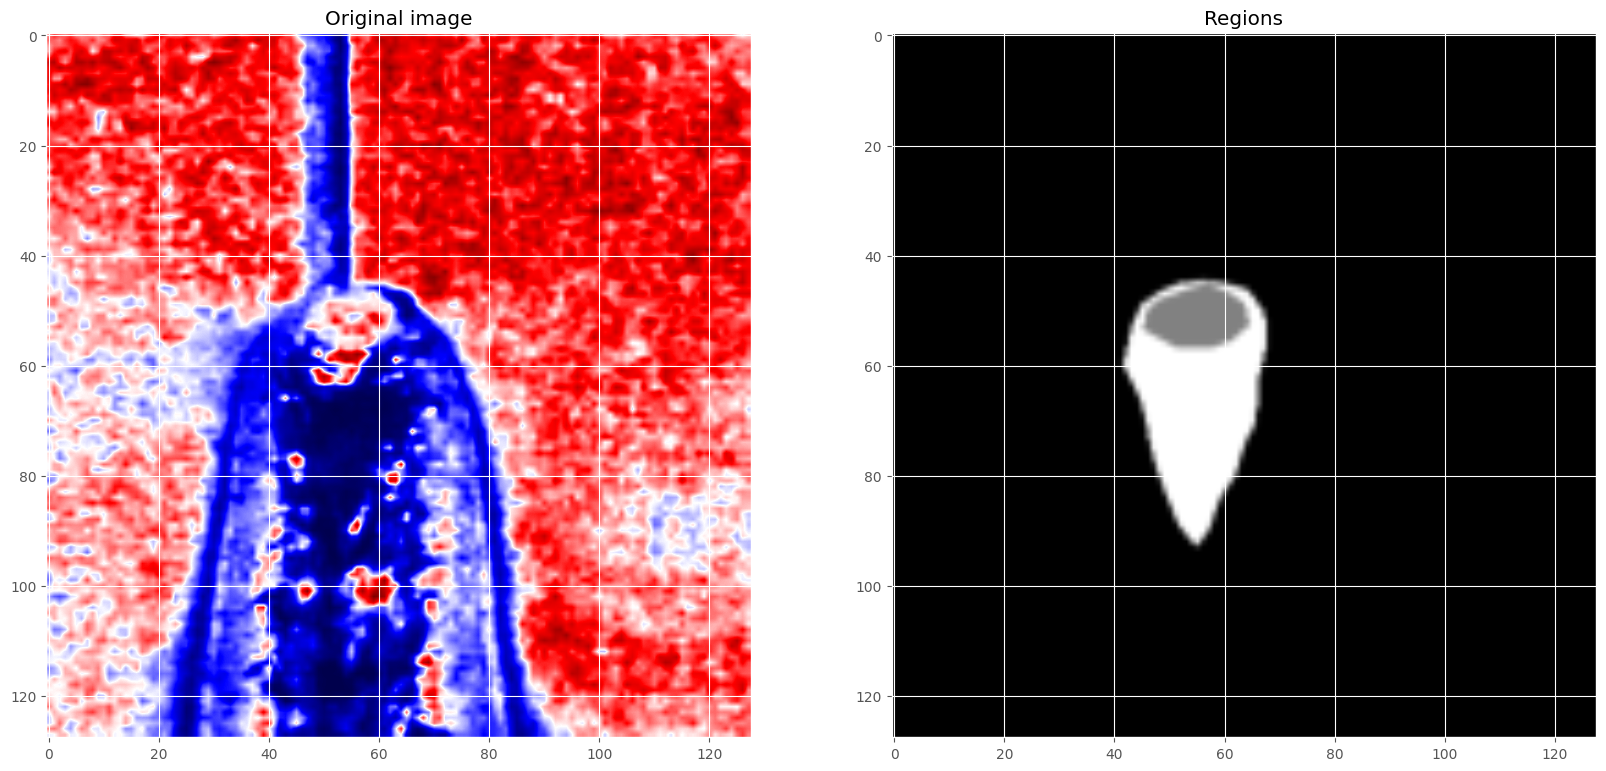

In [ ]:
# Visualize any random image along with the mask
ix = random.randint(0, len(X_train))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
#ax1.imshow(X_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax1.set_title('Original image')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Regions')

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [ ]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
input_img = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
#tf.keras.utils.plot_model(model, "model.png")
#model.summary()

'''callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('model-checkpoint', verbose=1, save_best_only=True, save_weights_only=True)
]'''

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
]
results = model.fit(X_train, y_train, validation_data=(X_valid,y_valid), batch_size=25, epochs=20, callbacks = callbacks)

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.3).astype(np.uint8)
preds_val_t = (preds_val > 0.3).astype(np.uint8)

print(X_train.shape)
print(y_train.shape)
print(preds_train.shape)
print(preds_train_t.shape)

2/2 [==============================] - 0s 23ms/step - loss: 0.2296 - accuracy: 0.9488


[0.22961094975471497, 0.9487616419792175]

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix].squeeze(), cmap='gray')
    ax[0].set_title('cavitar image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('molten pool')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    ax[2].set_title('Predicted')

    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    ax[3].set_title('Predicted binary');

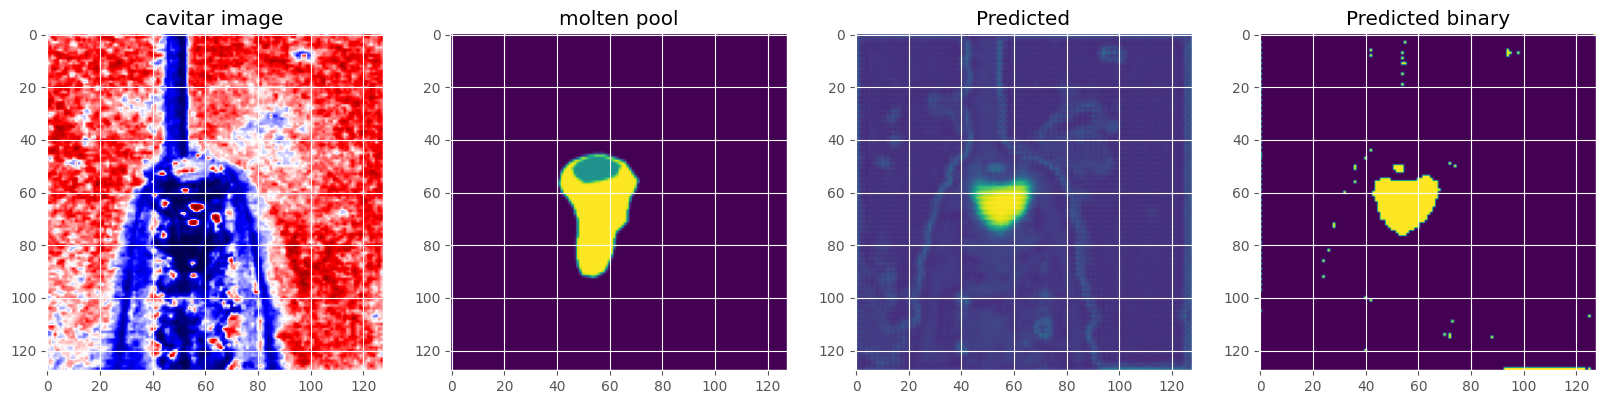

In [ ]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t)

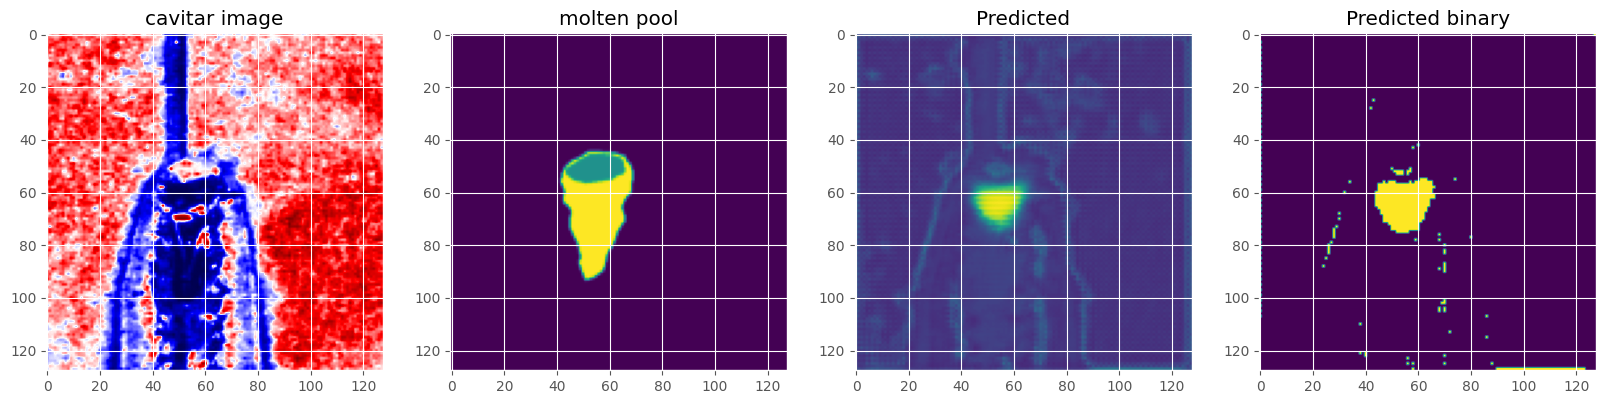

In [ ]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t)